In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

In [6]:
!pip install pandas openpyxl

from google.colab import files
uploaded = files.upload()

excel_file = list(uploaded.keys())[0]
df = pd.read_excel(excel_file, engine='openpyxl')

print(df.head())

csv_file = 'data.csv'
df.to_csv(csv_file, index=False)



Saving mainproject.xlsx to mainproject.xlsx
             Polymer                                             SMILES  P_MW  \
0  Polyphenylsulfone  COc1ccc(S(=O)(=O)c2ccc(Oc3ccc(-c4ccc(C)cc4)cc3...   NaN   
1  Polyphenylsulfone  COc1ccc(S(=O)(=O)c2ccc(Oc3ccc(-c4ccc(C)cc4)cc3...   NaN   
2  Polyphenylsulfone  COc1ccc(S(=O)(=O)c2ccc(Oc3ccc(-c4ccc(C)cc4)cc3...   NaN   
3  Polyphenylsulfone  COc1ccc(S(=O)(=O)c2ccc(Oc3ccc(-c4ccc(C)cc4)cc3...   NaN   
4  Polyphenylsulfone  COc1ccc(S(=O)(=O)c2ccc(Oc3ccc(-c4ccc(C)cc4)cc3...   NaN   

   P_wt%  surface tension (mN/m) pore maker pore maker molecular weight (Da)  \
0   15.0                     NaN        PEG                                    
1   15.0                     NaN        PEG                             1000   
2   15.0                     NaN        PEG                             1000   
3   15.0                     NaN        PEG                             1000   
4   15.0                     NaN        PEG                          

In [7]:
data = pd.read_csv('data.csv')

cleaning data

In [8]:
condition = ((df['organic compound'] == 'BSA') | (df['foulant'] == 'BSA'))
data = data[condition]

In [9]:
data.drop(columns = ['flux decline ratio (%)', 'flux recovery ratio (%) ',
       'reversible fouling ratio (%)', 'irreversible fouling ratio(%)',
       'Unnamed: 24','foulant','organic compound'] , inplace = True)

In [10]:
data = pd.get_dummies(data, columns=['Polymer','organic solvent' ,'SMILES','pore maker','pore maker','additive'])
print("\nDataFrame after One-Hot Encoding:")


DataFrame after One-Hot Encoding:


In [11]:
string_columns = data.select_dtypes(include=['object', 'string']).columns
print("Columns with string data:", string_columns)

Columns with string data: Index(['pore maker molecular weight (Da)'], dtype='object')


In [12]:
data['pore maker molecular weight (Da)'] = pd.to_numeric(data['pore maker molecular weight (Da)'], errors='coerce')

In [13]:
imputer = KNNImputer(n_neighbors=5,weights='distance')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

make test and train data

In [14]:
x = data_imputed.drop(columns=['water permeability (LMH/bar)', 'organic compound removal (%)'])
y =data_imputed[['water permeability (LMH/bar)', 'organic compound removal (%)']]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

1. decision tree regression

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [17]:
m = 0
r2_op = 0
for i in range(1,100) :
    model = DecisionTreeRegressor(random_state= i )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    if r2 > r2_op :
      r2_op = r2
      m = i
print(f"optimized R^2 score : {r2_op}")
print(f"optimized random_state : {m}")

optimized R^2 score : 0.8233271346519795
optimized random_state : 65


In [18]:
model = DecisionTreeRegressor(random_state= 65 )
model.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
train_error = mean_squared_error(y_train,y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(model.score(x_train, y_train))
print(f"optimized R^2 score : {r2}")
print(f"mean square error for train data: {train_error}")
print(f"mean square error for test date: {test_error}")
r2_scores_test = {}
for i, col in enumerate(y.columns):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    r2_scores_test[col] = r2
    print(f"R^2 Score for {col} on testing data: {r2}")

1.0
optimized R^2 score : 0.8233271346519795
mean square error for train data: 0.0
mean square error for test date: 2181.35245
R^2 Score for water permeability (LMH/bar) on testing data: 0.7789574328319473
R^2 Score for organic compound removal (%) on testing data: 0.7690734382477177


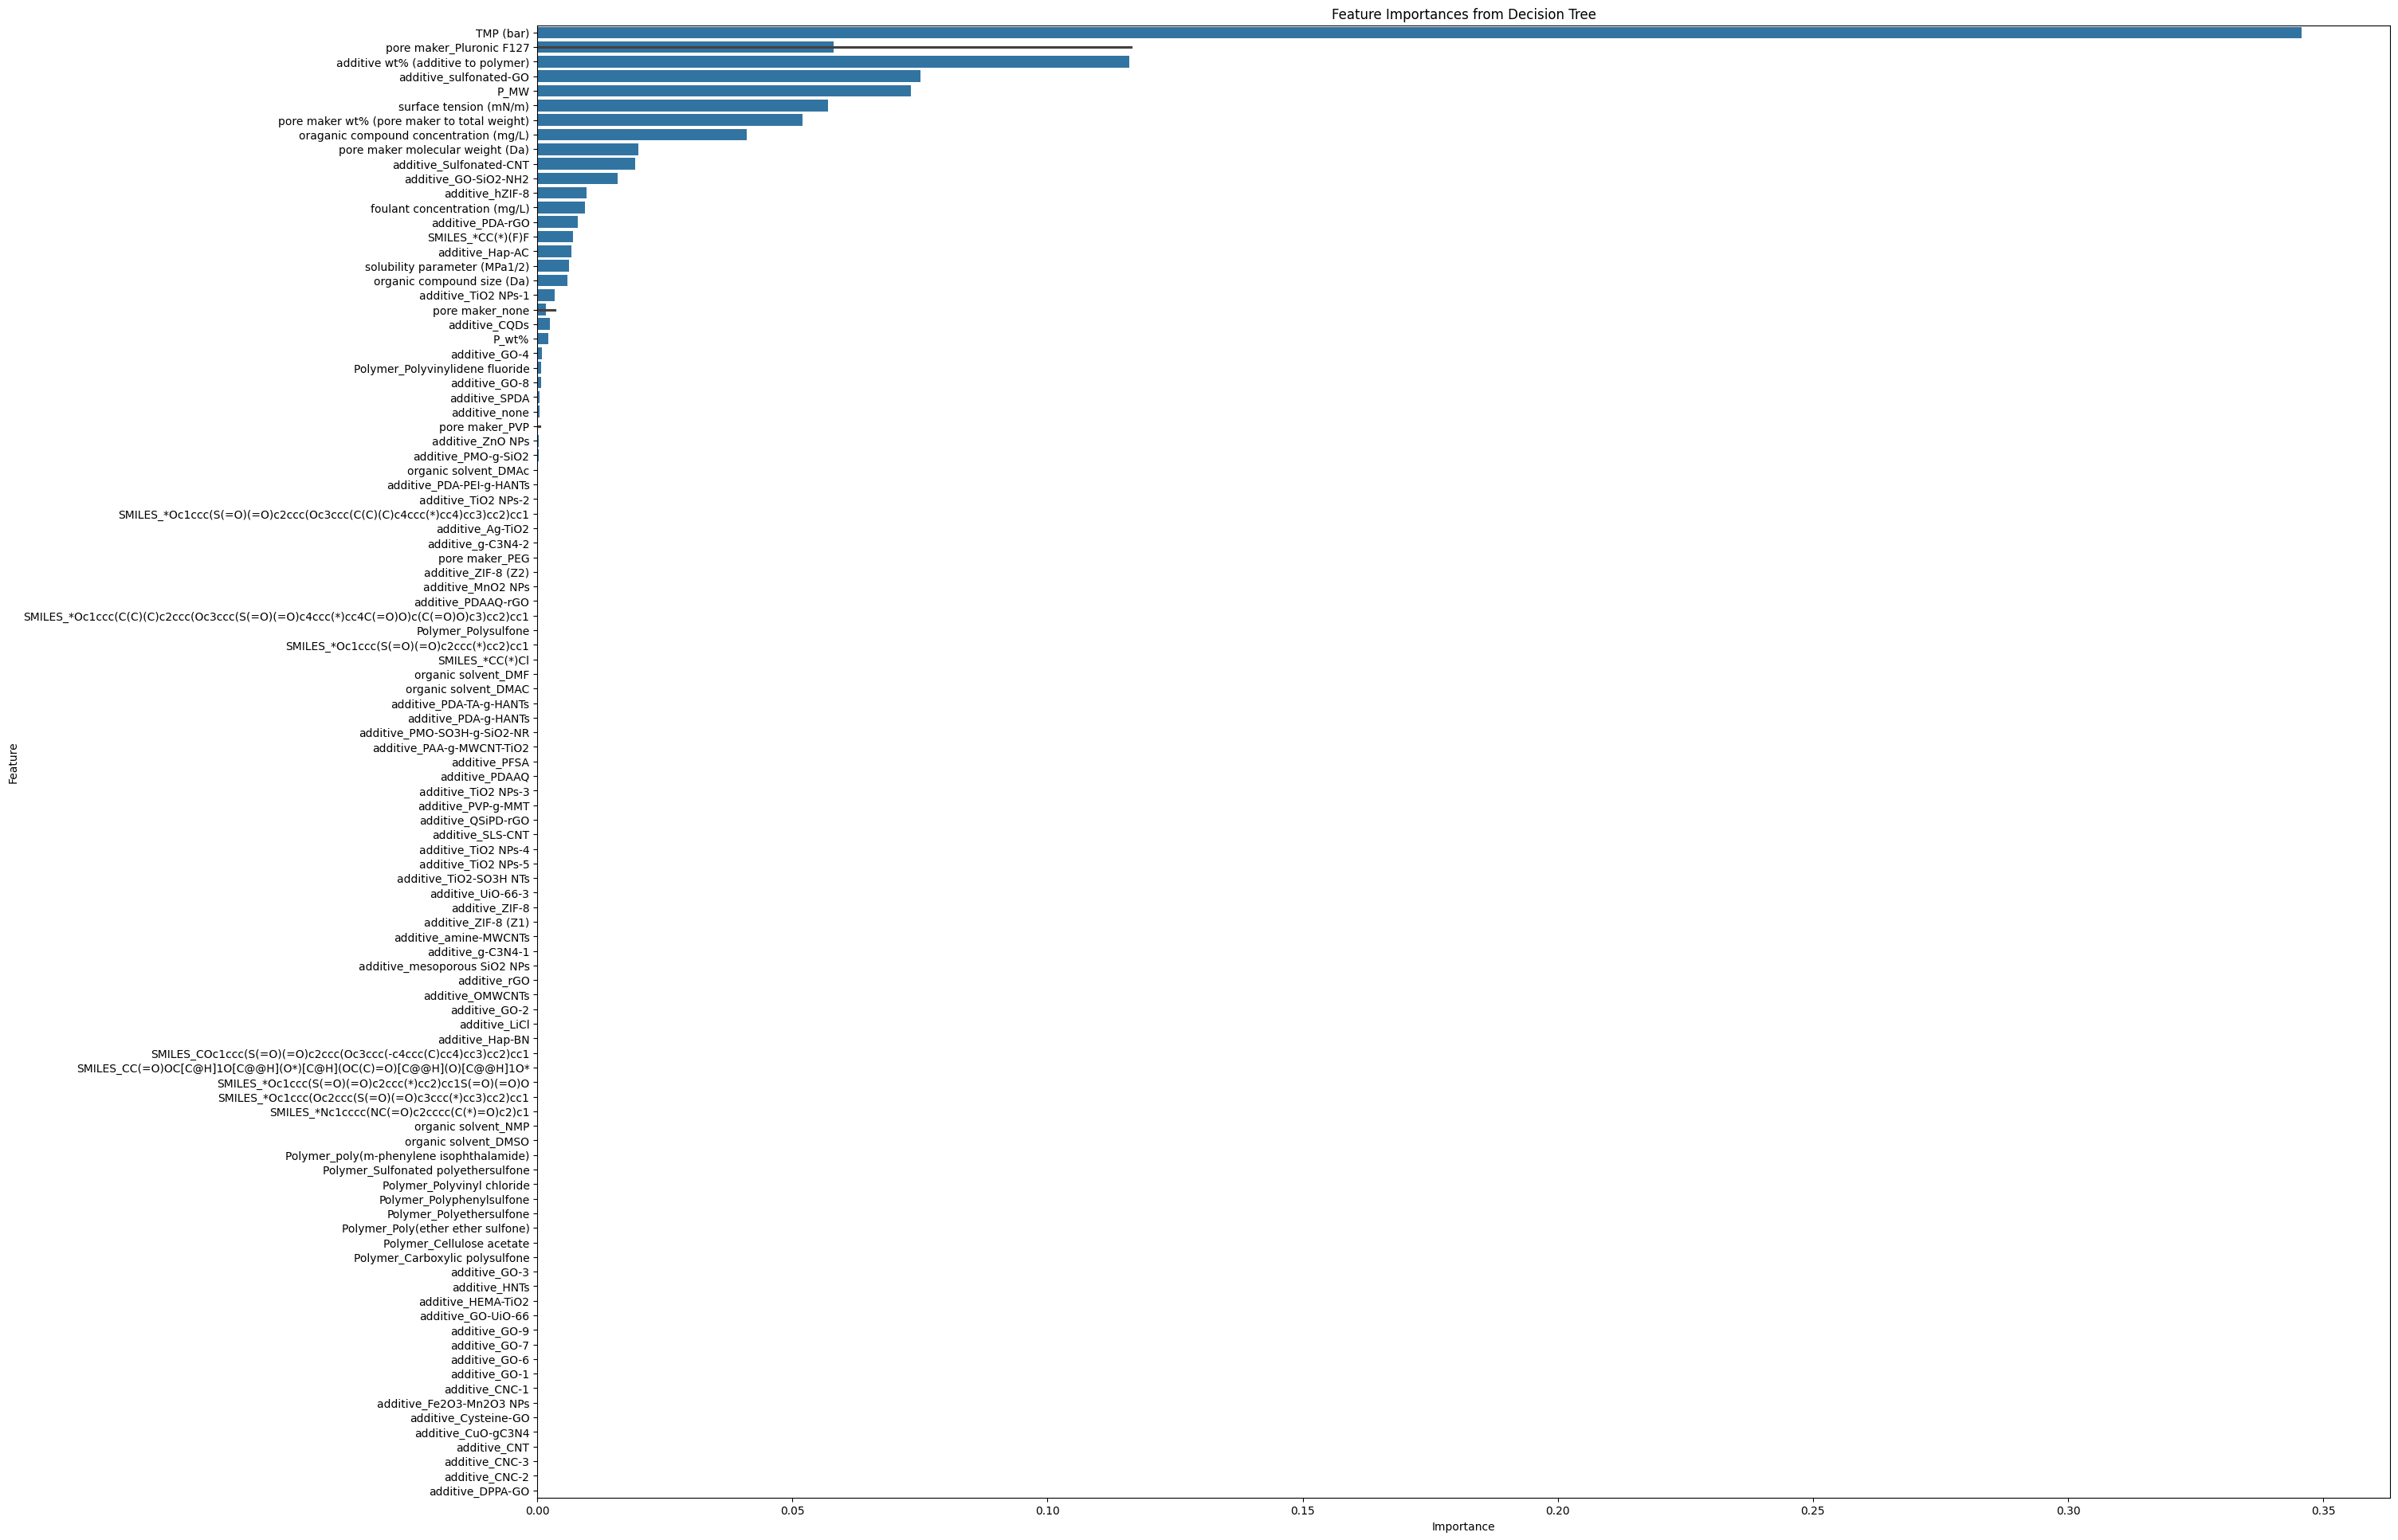

In [29]:
00importances = model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': x.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(30, 24))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Decision Tree')
plt.show()

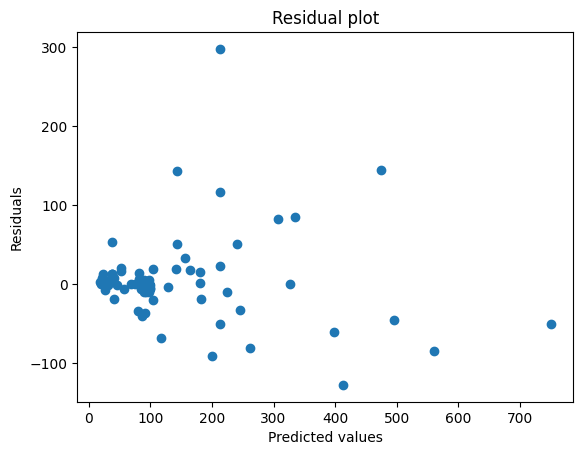

In [19]:
residuals = y_test - y_pred_test
train_residuals = y_train - y_pred_train
plt.scatter(y_pred_test, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

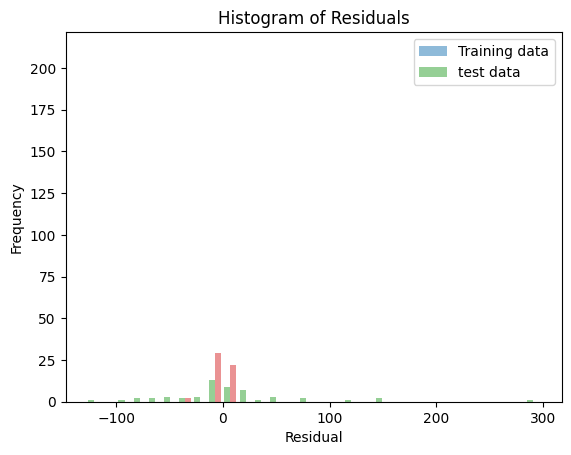

In [ ]:
plt.hist(train_residuals, bins=30, alpha=0.5, label='Training data')
plt.hist(residuals, bins=30, alpha=0.5, label='test data')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.show()

2.Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
n = 0
m = 0
r2_op  = 0
for i in range(1,100) :
    for j in range(1,100) :
       model = RandomForestRegressor(n_estimators = i, random_state = j)
       model.fit(x_train, y_train)
       y_pred = model.predict(x_test)
       r2 = r2_score(y_test, y_pred)
       if r2 > r2_op :
           r2_op = r2
           n = i
           m = j
print(f"optimized R^2 score : {r2_op}")
print(f"optimized n_estimators : {n}")
print(f"optimized random_state : {m}")

optimized R^2 score : 0.8618040506418063
optimized n_estimators : 9
optimized random_state : 11


In [ ]:
model = RandomForestRegressor(n_estimators=9, random_state=11)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
train_error = mean_squared_error(y_train,y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred)
print(model.score(x_train, y_train))
print(f"mean square error for train data: {train_error}")
print(f"mean square error for test date: {test_error}")
r2_scores_test = {}
for i, col in enumerate(y.columns):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    r2_scores_test[col] = r2
    print(f"R^2 Score for {col} on testing data: {r2}")

0.9579457450564848
mean square error for train data: 537.2317982739454
mean square error for test date: 1550.3814963079428
R^2 Score for water permeability (LMH/bar) on testing data: 0.8830069845155353
R^2 Score for organic compound removal (%) on testing data: 0.8406011167680775


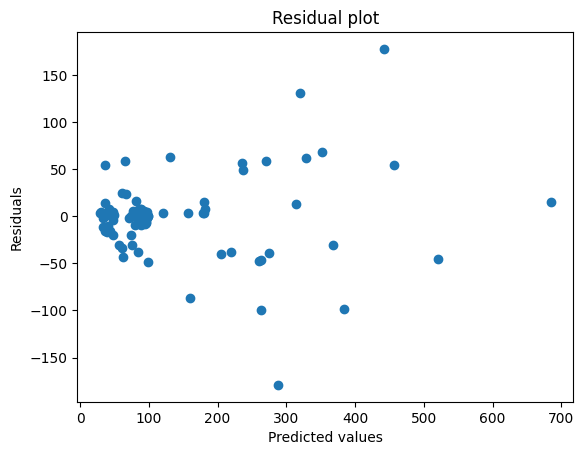

In [ ]:
residuals = y_test - y_pred_test
train_residuals = y_train - y_pred_train
plt.scatter(y_pred_test, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

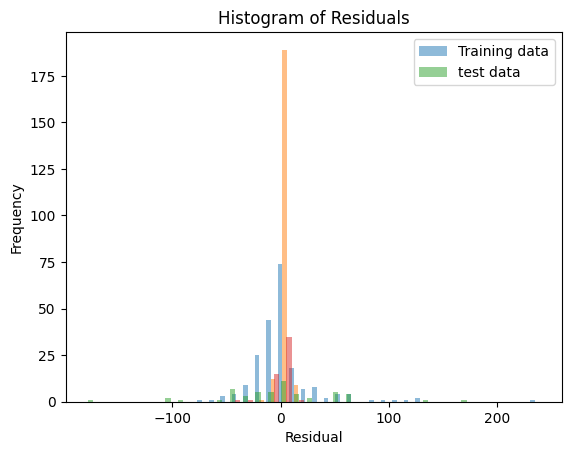

In [ ]:
plt.hist(train_residuals, bins=30, alpha=0.5, label='Training data')
plt.hist(residuals, bins=30, alpha=0.5, label='test data')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.show()

3.Gradient Boosting Regression

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
n = 0
m = 0
r2_op  = 0
for i in range(1,100) :
    for j in range(1,100) :
       model = XGBRegressor(n_estimators = i, random_state = j)
       model.fit(x_train, y_train)
       y_pred = model.predict(x_test)
       r2 = r2_score(y_test, y_pred)
       if r2 > r2_op :
           r2_op = r2
           n = i
           m = j
print(f"optimized R^2 score : {r2_op}")
print(f"optimized n_estimators : {n}")
print(f"optimized random_state : {m}")

optimized R^2 score : 0.8398357429984116
optimized n_estimators : 96
optimized random_state : 1


In [ ]:
model = XGBRegressor(n_estimators = 20, random_state = 96)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
train_error = mean_squared_error(y_train,y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred)
print(model.score(x_train, y_train))
print(f"mean square error for train data: {train_error}")
print(f"mean square error for test date: {test_error}")
r2_scores_test = {}
for i, col in enumerate(y.columns):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    r2_scores_test[col] = r2
    print(f"R^2 Score for {col} on testing data: {r2}")

0.9901510450438964
mean square error for train data: 120.46362165301508
mean square error for test date: 1953.312038431338
R^2 Score for water permeability (LMH/bar) on testing data: 0.8525543551073141
R^2 Score for organic compound removal (%) on testing data: 0.8021595912088884


In [1]:
residuals = y_test - y_pred_test
train_residuals = y_train - y_pred_train
plt.scatter(y_pred_test, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

NameError: name 'y_test' is not defined

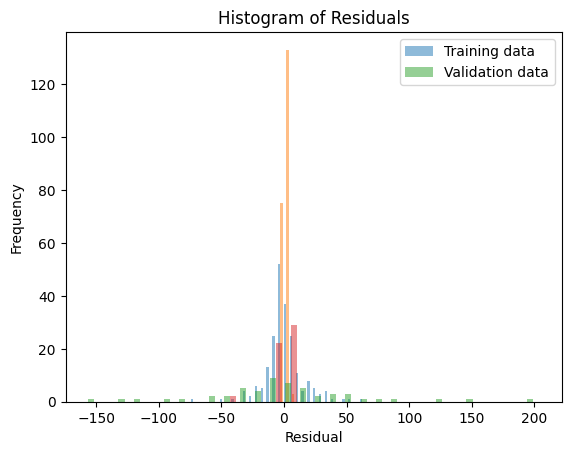

In [ ]:
plt.hist(train_residuals, bins=30, alpha=0.5, label='Training data')
plt.hist(residuals, bins=30, alpha=0.5, label='Validation data')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.show()